## This is an advanced lane finding project
The pipeline can be designed following the steps below:

 * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 * Apply a distortion correction to raw images.
 * Use color transforms, gradients, etc., to create a thresholded binary image.
 * Apply a perspective transform to rectify binary image ("birds-eye view").
 * Detect lane pixels and fit to find the lane boundary.
 * Determine the curvature of the lane and vehicle position with respect to center.
 * Warp the detected lane boundaries back onto the original image.
 * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [46]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Calculate calibration parameters from calibration images

In [62]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(0)
    #plt.figure()    
    #plt.imshow(img)
    #plt.show()
#print(images)
#cv2.destroyAllWindows()

## Correct for distortion in images

In [49]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    #pickle.dump()
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return [undist, ret, mtx, dist]



# Make a list of calibration images
raw_images = glob.glob('./test_images/*.jpg')
#print(raw_images)

for fname2 in raw_images:
    img2 = cv2.imread(fname2)
    undistorted, ret, mtx, dist = cal_undistort(img2, objpoints, imgpoints)
    cv2.imwrite(os.path.join('./calibrated_images/',fname2[14:]), undistorted)
    #print(fname2[14:])

## Create a thresholded binary image

720
720
720
720
720
720
720
720


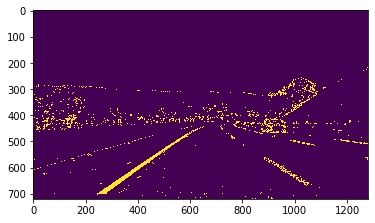

In [65]:
def binary_transformation(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary=cv2.bitwise_or(sxbinary,s_binary)
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return binary
    


# Make a list of calibration images
calibrated_images = glob.glob('./calibrated_images/*.jpg')
#print(raw_images)

for fname3 in calibrated_images:
    img3 = cv2.imread(fname3)
    binary_images = binary_transformation(img3)
    cv2.imwrite(os.path.join('./binary_images/',fname3[20:]), binary_images*255)
    #print(fname3[20:])
        #cv2.imshow('img',img)
        #cv2.waitKey(0)
    #plt.figure()    
    plt.imshow(binary_images)
    print(binary_images.shape[0])
    #plt.show()
#print(images)
#cv2.destroyAllWindows()

## Store the undistorted calibration images for sanity check

In [ ]:
# Make a list of calibration images
calib_images = glob.glob('./camera_cal/*.jpg')
#print(raw_images)

for fname4 in calib_images:
    img4 = cv2.imread(fname4)
    undistorted_calib,ret, mtx, dist = cal_undistort(img4, objpoints, imgpoints)
    cv2.imwrite(os.path.join('./undistorted_calibration_images/',fname4[13:]), undistorted_calib)
    #print(fname4)

## Rectify the images using perspective transform

In [68]:
def warp_image(binary_image):   
    
    imgx=binary_image.shape[1]
    imgy=binary_image.shape[0]
    src = np.float32([[200,720], [1150,720], [750,450], [600,450]])
    #print([corners[0,0], corners[7,0], corners[47,0], corners[40,0]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M=cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(binary_image, M, (imgx, imgy),flags=cv2.INTER_LINEAR)
        
    return warped
    
    
# Make a list of calibration images
binary_images = glob.glob('./binary_images/*.jpg')
#print(raw_images)

for fname5 in binary_images:
    img5 = cv2.imread(fname5)
    warped_images=warp_image(img5)
    cv2.imwrite(os.path.join('./warped_images/',fname5[16:]), warped_images)
    #print(fname5[16:])

## Detect lane pixels and fit to find the lane boundary

## Determine the curvature of the lane and vehicle position

## Warp the detected lane boundaries back onto the original image

## Output video with overlaid information